In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.decomposition import PCA
import seaborn as sns
from newspaper import Article
import requests
from bs4 import BeautifulSoup

In [3]:
data = pd.read_csv("./OnlineNewsPopularity.csv")

In [4]:
data.shape

(39644, 61)

In [5]:
def cleancols(cols):
    x = [y.lower().strip() for y in cols]
    return x

In [6]:
data.columns = cleancols(data.columns)
y_labels = data['shares'] #the feature to be predicted
df = data.drop(columns = ['url','timedelta','shares'],axis = 1) #url and timedelta are of no use to us

In [7]:
url = "https://www.bbc.com/news/world"
page = requests.get(url)
soup = BeautifulSoup(page.content,'html.parser')
imgnews = soup.findAll('a',attrs = {'class':'gs-c-promo-heading gs-o-faux-block-link__overlay-link gel-pica-bold nw-o-link-split__anchor'})

In [33]:
def fetch_top_newsarts(api_key, country='us', page_size=100):
    url = 'https://newsapi.org/v2/top-headlines'
    params = {
        'apiKey': api_key,
        'country': country,
        'pageSize': page_size
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        articles = data['articles']
        # Extracting news URLs from articles
        newsarts = [article['url'] for article in articles]
        return newsarts
    else:
        print(f"Error: {response.status_code} - {response.reason}")
        return []

if __name__ == "__main__":
    api_key = "207a0289ae3d42cc9989b83d2f5083e"
    newsarts = fetch_top_newsarts(api_key)
    print("List of News URLs:")
    print(newsarts)

List of News URLs:
['https://apnews.com/article/japan-helicopters-down-pacific-73f8ec2a05bf7ee4b77d08f778dd086e', 'https://www.mmafighting.com/2024/4/20/24134584/devin-haney-vs-ryan-garcia-live-round-by-round-updates', 'https://abcnews.go.com/US/2-dead-14-hospitalized-memphis-block-party-shooting/story?id=109470271', 'https://www.wsj.com/world/middle-east/white-house-scramble-avert-middle-east-war-fc012c43', 'https://bleacherreport.com/articles/10117834-lebron-james-lakers-ripped-by-nba-fans-for-3q-collapse-in-loss-to-jokic-nuggets', 'https://www.espn.com/nba/story/_/id/39985132/no-plans-shut-joel-embiid-latest-injury-scare', 'https://removed.com', 'https://www.bloomberg.com/news/articles/2024-04-21/tiktok-set-to-remove-executive-tasked-with-fending-off-us-claims', 'https://www.foxnews.com/us/deceased-protester-who-lit-himself-on-fire-outside-trump-hush-money-trial-once-worked-for-democrat-congressman', 'https://www.tmz.com/2024/04/20/bethenny-frankel-post-brutally-honest-tribute-mom-d

In [35]:
pca = PCA(n_components = 12)
df_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)
df_red = pca.fit_transform(df_scaled) #applying PCA on the standardized data
explainedfeats = pd.DataFrame(pca.components_,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10','PC-11','PC-12'],columns = df.columns)

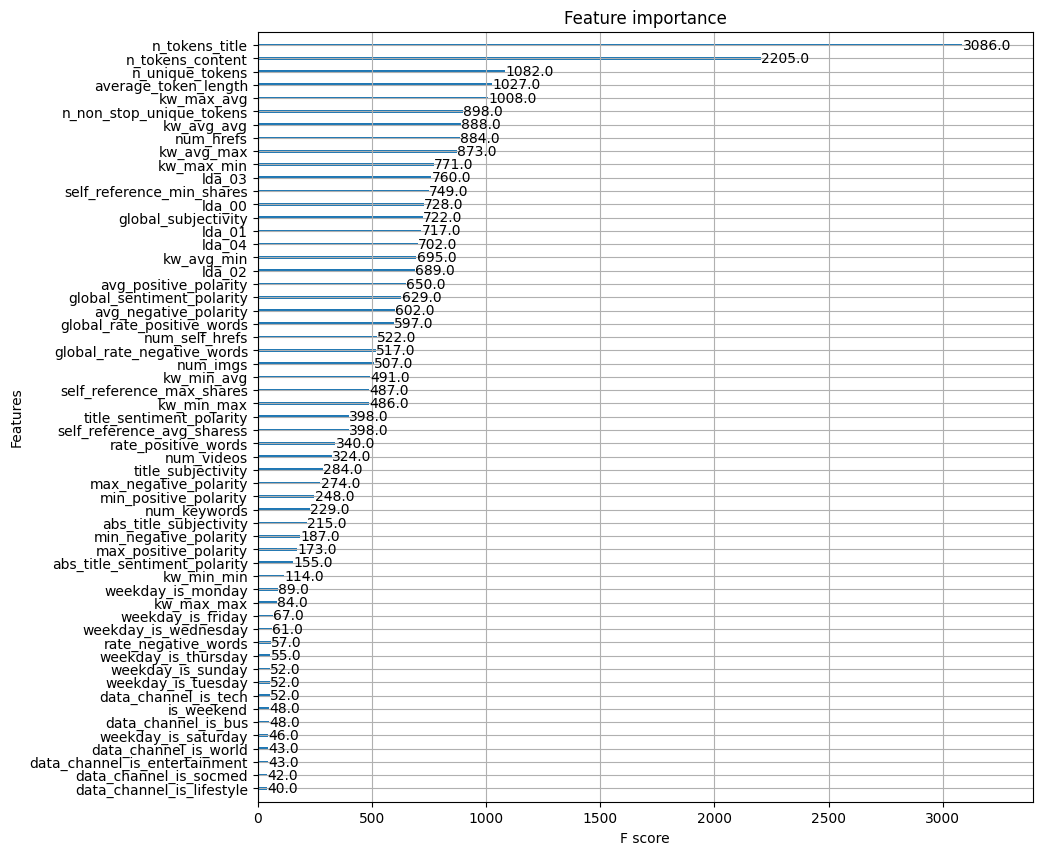

In [36]:
xgb = XGBRegressor(max_depth = 10,random_state = 42)
xgb.fit(df,y_labels)
fig, ax = plt.subplots(1,1,figsize=(10,10))
impplot = plot_importance(xgb,ax = ax)
plt.show()

In [37]:
impfeats = [impplot.get_yticklabels()[::-1][i].get_text() for i in range(0,20)]
print(impfeats)

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'average_token_length', 'kw_max_avg', 'n_non_stop_unique_tokens', 'kw_avg_avg', 'num_hrefs', 'kw_avg_max', 'kw_max_min', 'lda_03', 'self_reference_min_shares', 'lda_00', 'global_subjectivity', 'lda_01', 'lda_04', 'kw_avg_min', 'lda_02', 'avg_positive_polarity', 'global_sentiment_polarity']


In [44]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
from textblob import TextBlob #for subjectivity and polarity purpose

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amate\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [45]:
def tokenizetext(text):
    return word_tokenize(text)
def words(text):
    l = [word for word in word_tokenize(text) if word.isalpha()]
    return l
def unique_words(text):
    return list(set(words(text)))
def rate_uni_words(text):
    uni_words = len(unique_words(text))/len(words(text))
    return uni_words
def avglengthtoken(text):
    w = words(text)
    sum = 0
    for item in w:
        sum+=len(item)
    avglen = sum/len(w)
    return avglen
def n_non_stop_unique_tokens(text):
    uw = unique_words(text)
    n_uw = [item for item in uw if item not in stopwords]
    w = words(text)
    n_w = [item for item in w if item not in stopwords]
    rate_nsut = len(n_uw)/len(n_w)
    return rate_nsut
def numlinks(article):
    return len(BeautifulSoup(sampletext.html).findAll('link'))
def get_subjectivity(a_text):
    return a_text.sentiment.subjectivity
def get_polarity(a_text):
    return a_text.sentiment.polarity
def word_polarity(words):
    pos_words = []
    ppos_words = [] # polarity of pos words
    neg_words = []
    pneg_words = [] # polarity of negative words
    neu_words = []
    pneu_words = [] # polarity of neutral words
    for w in words:
        an_word = TextBlob(w)
        val = an_word.sentiment.polarity
        if val > 0:
            pos_words.append(w)
            ppos_words.append(val)
        if val < 0:
            neg_words.append(w)
            pneg_words.append(val)
        if val == 0 :
            neu_words.append(w)
            pneu_words.append(val)
    return pos_words,ppos_words,neg_words,pneg_words,neu_words,pneu_words
def avg_pol_pw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[1])/len(res[0])
def avg_pol_nw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[3])/len(res[2])

In [ ]:
finrows = []
for article_url in newsarts[0:25]:
    try:
        sampletext = Article(article_url, language='en')
        sampletext.download()
        sampletext.parse()
        sampletext.nlp() 
        
        row = {}
        row['n_tokens_title'] = len(sampletext.title.split())
        row['n_tokens_content'] = len(sampletext.text.split())
        row['n_unique_tokens'] = len(set(sampletext.text.split()))
        row['average_token_length'] = sum(len(word) for word in sampletext.text.split()) / len(sampletext.text.split())
        row['n_non_stop_unique_tokens'] = len([word for word in sampletext.text.split() if word.lower() not in stopwords])
        row['num_hrefs'] = len(sampletext.html.split('<a')) - 1
        
        analysed_text = TextBlob(sampletext.text)
        row['global_subjectivity'] = analysed_text.sentiment.subjectivity
        row['avg_positive_polarity'] = analysed_text.sentiment.polarity
        row['global_sentiment_polarity'] = analysed_text.sentiment.polarity
        finrows.append(row)
    except Exception as e:
        print(f"Error processing article: {article_url}")
        print(e)

# Converting the list to a DataFrame
masterdf = pd.DataFrame(finrows, columns=['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 
                                           'average_token_length', 'n_non_stop_unique_tokens', 
                                           'num_hrefs', 'global_subjectivity', 
                                           'avg_positive_polarity', 'global_sentiment_polarity'])

In [48]:
masterdf.shape

(18, 9)

In [49]:
df_reduced = df[masterdf.columns]

In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(df_reduced, y_labels, test_size = 0.2, shuffle = True, random_state = 42)

XGBOOST

In [51]:
xgb2 = XGBRegressor(random_state = 42)
paramsxgb = {'max_depth':[5,20,50,100]}
gsc = GridSearchCV(estimator = xgb2,param_grid = paramsxgb, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'max_depth': 5}

In [52]:
xgb2.max_depth = gscres.best_params_['max_depth']
boost = ['gbtree','gblinear']
rmsescores = {}
for b in boost:
    xgb2.booster = b
    xgb2.fit(xtrain,ytrain)
    predicted = xgb2.predict(xtest)
    rmsescores['xgb-'+b] = RMSE(ytest,predicted,squared = False)
    print("RMSE error with {} booster is {} :".format(b,RMSE(ytest,predicted,squared = False)))

RMSE error with gbtree booster is 11431.556668488993 :
[13:52:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE error with gblinear booster is 10973.182458430345 :


In [53]:
xgb2.booster = 'gblinear'

RandomForestRegressor

In [54]:
rf = RandomForestRegressor(random_state = 42)
paramsrf = {'max_depth':[5,20,50,100]}
gsc = GridSearchCV(estimator = rf,param_grid = paramsrf, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'max_depth': 5}

In [55]:
rf.max_depth = gscres.best_params_['max_depth']
rf.fit(xtrain,ytrain)
predictedrf = rf.predict(xtest)
rmsescores['rf'] = RMSE(ytest,predictedrf,squared = False)
print("RMSE error with Random Forest Regressor is {} :".format(RMSE(ytest,predicted,squared = False)))

RMSE error with Random Forest Regressor is 10973.182458430345 :


Linear Regression (RidgeCV): linear regression with l2 regularization and in-built CV

In [56]:
lr = RidgeCV(alphas = [0.001,0.1,1,5,10,100],scoring = 'neg_root_mean_squared_error', cv = None, store_cv_values = True)
lr.fit(xtrain,ytrain)

RidgeCV(alphas=[0.001, 0.1, 1, 5, 10, 100],
        scoring='neg_root_mean_squared_error', store_cv_values=True)

In [57]:
predictedlr = lr.predict(xtest)
rmsescores['ridgecv'] = RMSE(ytest,predictedlr,squared = False)
print("RMSE error with Linear Regression via RidgeCV is {} :".format(RMSE(ytest,predictedlr,squared = False)))

RMSE error with Linear Regression via RidgeCV is 10952.058107466977 :


RMSE score for RidgeCV regression is found to be lowest compared to XGBoost and Random Forest Regressor

CatBoost

In [58]:
cb = CatBoostRegressor(verbose = 0,random_state = 42,eval_metric = 'RMSE')
paramscb = {'iterations':[1,10,50,100],'learning_rate':[0.03,0.1,0.5,1],'depth':[3,5,8,10]}
gsc = GridSearchCV(estimator = cb,param_grid = paramscb, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.03}

In [59]:
cb.iterations = gscres.best_params_['iterations']
cb.learning_rate = gscres.best_params_['learning_rate']
cb.depth = gscres.best_params_['depth']
cb.fit(xtrain,ytrain)

In [60]:
predictedcb = cb.predict(xtest)
rmsescores['catboost'] = RMSE(ytest,predictedcb,squared = False)
print("RMSE error with CatBoost is {} :".format(RMSE(ytest,predictedcb,squared = False)))

RMSE error with CatBoost is 11308.71909240918 :


EVALUATION RESULTS

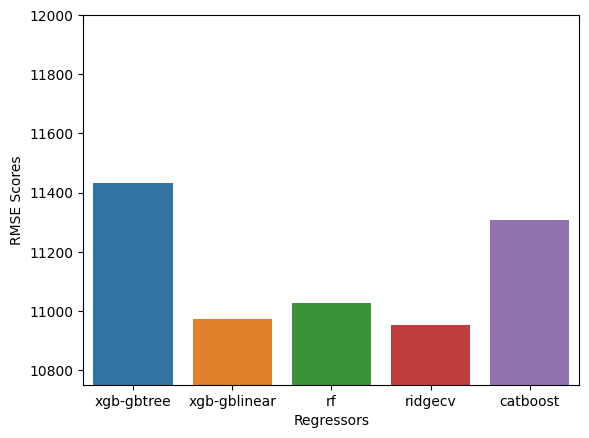

In [61]:
ax = sns.barplot(x = list(rmsescores.keys()),y = list(rmsescores.values()))
ax.set_ylim(10750,12000)
ax.set_xlabel('Regressors')
ax.set_ylabel('RMSE Scores')
plt.show()

FINAL PREDICTION

In [79]:
predxgb = xgb2.predict(masterdf)
predxgb = [abs(val) for val in predxgb]
if len(newsarts[:25]) != len(predxgb):
    # Truncate the longer list to match the length of the shorter list
    min_length = min(len(newsarts[:25]), len(predxgb))
    newsarts_truncated = newsarts[:min_length]
    predxgb_truncated = predxgb[:min_length]
    
    # Create a dictionary with truncated 'Links' and 'Predicted Virality' lists
    xgbdata = {'Links': newsarts_truncated, 'Predicted Virality': predxgb_truncated}
else:
    xgbdata = {'Links': newsarts[:25], 'Predicted Virality': predxgb}
pd.DataFrame(xgbdata).reindex(np.arange(0,17,1))

,Links,Predicted Virality
0,https://apnews.com/article/japan-helicopters-d...,24526.503906
1,https://www.mmafighting.com/2024/4/20/24134584...,9284.712891
2,https://abcnews.go.com/US/2-dead-14-hospitaliz...,5079.344238
3,https://www.wsj.com/world/middle-east/white-ho...,8303.560547
4,https://bleacherreport.com/articles/10117834-l...,11491.821289
5,https://www.espn.com/nba/story/_/id/39985132/n...,2710.171875
6,https://removed.com,20672.986328
7,https://www.bloomberg.com/news/articles/2024-0...,8748.386719
8,https://www.foxnews.com/us/deceased-protester-...,11810.407227
9,https://www.tmz.com/2024/04/20/bethenny-franke...,15811.544922
